In [77]:
import numpy as np
import matplotlib.pyplot as plt
from psfpy.corrector import calculate_covering, ArrayCorrector
import matplotlib.patches as patches

In [2]:
def get_padded_img_section(padded_img, x, y, psf_size) -> np.ndarray:
    """ Assumes an image is padded by ((2*psf_size, 2*psf_size), (2*psf_size, 2*psf_size))"""
    x_prime, y_prime = x + 2*psf_size, y + 2*psf_size
    return padded_img[x_prime: x_prime + psf_size, y_prime: y_prime + psf_size]


def set_padded_img_section(padded_img, x, y, psf_size, new_values) -> None:
    assert new_values.shape == (psf_size, psf_size)
    x_prime, y_prime = x + 2*psf_size, y + 2*psf_size
    padded_img[x_prime: x_prime + psf_size, y_prime: y_prime + psf_size] = new_values


def add_padded_img_section(padded_img, x, y, psf_size, new_values) -> None:
    assert new_values.shape == (psf_size, psf_size)
    prior = get_padded_img_section(padded_img, x, y, psf_size)
    set_padded_img_section(padded_img, x, y, psf_size, new_values + prior)

In [165]:
def new_calculate_covering(image_shape: tuple[int, int], size: int) -> np.ndarray:
    half_size = np.ceil(size / 2).astype(int)
    quarter_size = np.ceil(size / 4).astype(int)
    # x1, y1 are the primary grid. x2, y2 are the offset grid. Together they fully cover the image twice.
    x1 = np.arange(0, image_shape[0], size)
    y1 = np.arange(0, image_shape[1], size)

    x2 = np.arange(-half_size, image_shape[0]+half_size, size)
    y2 = np.arange(-half_size, image_shape[1]+half_size, size)

    x3 = np.arange(-half_size, image_shape[0]+half_size, size)
    y3 = np.arange(0, image_shape[1], size)

    x4 = np.arange(0, image_shape[0], size)
    y4 = np.arange(-half_size, image_shape[1]+half_size, size)

    x5 = np.arange(-quarter_size, image_shape[0]+quarter_size, size)
    y5 = np.arange(-quarter_size, image_shape[1]+quarter_size, size)

    x6 = np.arange(-quarter_size, image_shape[0]+quarter_size, size)
    y6 = np.arange(0, image_shape[1], size)

    x7 = np.arange(0, image_shape[0], size)
    y7 = np.arange(-quarter_size, image_shape[1]+quarter_size, size)

    x8 = np.arange(size, image_shape[0]+size, size)
    y8 = np.arange(size, image_shape[1]+size, size)

    x1, y1 = np.meshgrid(x1, y1)
    x2, y2 = np.meshgrid(x2, y2)
    x3, y3 = np.meshgrid(x3, y3)
    x4, y4 = np.meshgrid(x4, y4)
    x5, y5 = np.meshgrid(x5, y5)
    x6, y6 = np.meshgrid(x6, y6)
    x7, y7 = np.meshgrid(x7, y7)
    x8, y8 = np.meshgrid(x8, y8)


    x1, y1 = x1.flatten(), y1.flatten()
    x2, y2 = x2.flatten(), y2.flatten()
    x3, y3 = x3.flatten(), y3.flatten()
    x4, y4 = x4.flatten(), y4.flatten()
    x5, y5 = x5.flatten(), y5.flatten()
    x6, y6 = x6.flatten(), y6.flatten()
    x7, y7 = x7.flatten(), y7.flatten()
    x8, y8 = x8.flatten(), y8.flatten()


    x = np.concatenate([x1, x2, x3, x4])
    y = np.concatenate([y1, y2, y3, y4])
    print(x.shape, y.shape)
    return np.stack([x, y], -1)

In [166]:
def see_apodization_impact(corners, img_shape, patch_size):
    counts = np.zeros(img_shape)
    counts = np.pad(counts, ((2*patch_size, 2*patch_size), (2*patch_size, 2*patch_size)), mode='constant')

    xx, yy = np.meshgrid(np.arange(patch_size), np.arange(patch_size))
    apodization_window = np.square(np.sin((xx+0.5)*np.pi/patch_size)) * np.square(np.sin((yy+0.5)*np.pi/patch_size))
    apodization_window = np.square(np.sin((xx+0.5)*(np.pi/patch_size))) * np.square(np.sin((yy+0.5)*(np.pi/patch_size)))
    #apodization_window = np.sin((xx+0.5)*np.pi/patch_size) *np.sin((yy+0.5)*np.pi/patch_size)

    # window1d = create_window(patch_size, "cosine")
    # apodization_window = np.sqrt(np.outer(window1d, window1d))

    for i, (x, y) in enumerate(corners):
        prior = get_padded_img_section(counts, x, y, patch_size)
        set_padded_img_section(counts, x, y, patch_size, prior + apodization_window)
    return counts

In [171]:
img_size = 2048
patch_size = 400

cc = new_calculate_covering((img_size, img_size), patch_size)
counts = see_apodization_impact(cc, (img_size, img_size), patch_size)

(169,) (169,)


In [153]:
len(cc)

169

In [140]:
# img_size = 2048
# patch_size = 400
#
# ac = ArrayCorrector.load("punch_array_corrector.psfpy")
# cc = np.array(list(ac._evaluations.keys()))
# counts = see_apodization_impact(cc, (img_size, img_size), patch_size)

In [173]:
np.max(counts)

1.0000000000000007

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_28588/1343766235.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


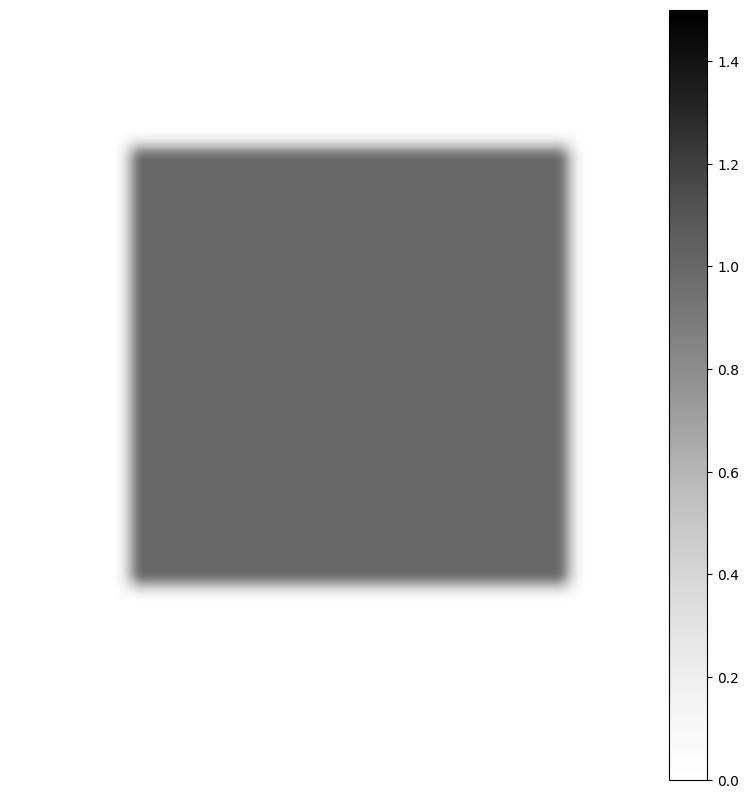

In [172]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(counts, origin='lower', cmap='Greys', interpolation='none', vmin=0, vmax=1.5)
ax.set_axis_off()
fig.colorbar(im)
fig.show()

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_28588/292878381.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


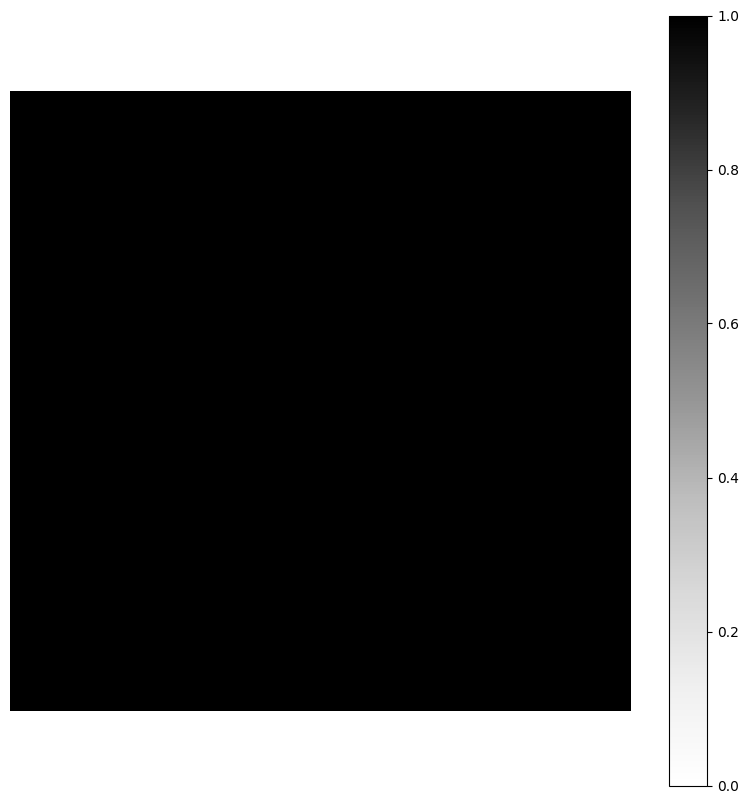

In [122]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(counts[patch_size*2:img_size+patch_size*2, patch_size*2:img_size+patch_size*2], origin='lower', cmap='Greys', interpolation='none', vmin=0, vmax=1)
ax.set_axis_off()
fig.colorbar(im)
fig.show()

In [64]:
len(cc)

169

36 49 42 42

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_28588/2138135683.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


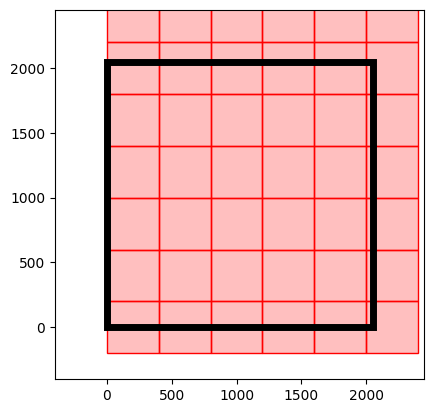

In [76]:
img_size = 2048
patch_size = 400

counts = np.zeros((img_size, img_size))
cc = calculate_covering((img_size, img_size), patch_size)[36+49+42:36+49+42+42]
fig, ax = plt.subplots()
for i, (x,y) in enumerate(cc):
    random_color = (np.random.random(), np.random.random(), np.random.random(), 0.1)
    red = (1, 0, 0, 0.25)
    blue = (0, 0, 1, 0.25)
    rect = patches.Rectangle((x, y), patch_size, patch_size, linewidth=1,
                             edgecolor='r',
                             facecolor=red)
    ax.add_patch(rect)

    counts[np.max([0, y]):np.min([img_size, y+patch_size]), np.max([0, x]):np.min([img_size, x+patch_size])] += 1
rect = patches.Rectangle((0, 0), img_size, img_size, linewidth=5, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.set_xlim((-patch_size, img_size+patch_size))
ax.set_ylim((-patch_size, img_size+patch_size))
ax.set_aspect(1)
fig.show()

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_45604/2870208533.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


2.0 2.0


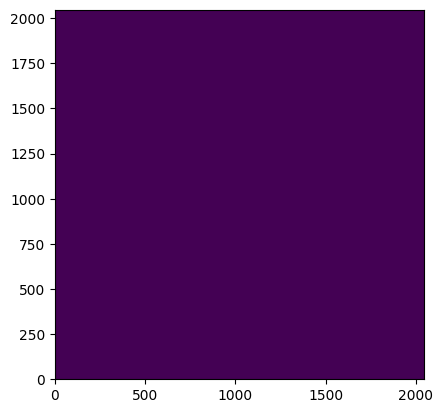

In [4]:
fig, ax = plt.subplots()
ax.imshow(counts==2, origin='lower')
fig.show()
print(np.min(counts), np.max(counts))